# Building a customized NER for Course Recommender


`Description`

NER stands for Named Entity Recognition. It is a subtask of Natural Language Processing (NLP) that involves identifying and extracting named entities from unstructured text. Named entities are specific pieces of information that are mentioned in the text and refer to real-world objects such as people, places, organizations, and dates.

The goal of NER is to automatically identify and classify these named entities in a given text. This can be useful in many applications, such as information extraction, question answering, and sentiment analysis. NER systems typically use machine learning algorithms, such as Conditional Random Fields (CRFs) or Recurrent Neural Networks (RNNs), to automatically identify and label named entities in text.

In this notebook, we collect all the training data, prepare it for a NER model and train the model. The final output of this notebook would be a trained custom NER model that would extract Course Name related entities such as abbreviation, full-name etc.

`Example`

Input Q: "*Im looking for all the items similar to applied data sci, are there any?*"

NER Model Output: "applied data sci"

This output would be used to search for a matching index in ElasticSearch DB, and would return a UUID mapped to "Applied Data Science" course.


`Citations`

Used for generating training data:
- Alexa API: https://developer.amazon.com/en-US/docs/alexa/alexa-smart-properties/alexa-for-residential-endpoint-api.html
- ChatGPT Warpper: https://github.com/acheong08/ChatGPT

---
### Contents:

1. Imports
2. Motivation
3. Directory Setup
4. Dataset
    - 4.1. Annotation Schemata
    - 4.2. File Structure
    - 4.3. Generating Data
        - 4.3.1. Using chatGPT to generate Seed Questions
        - 4.3.2. Using chatGPT to generate Utternace Templates
        - 4.3.3. Using chatGPT to generate Course Acronyms, Abbrevaiations, short-names


5. Preprocessing
    - A. Gather Entities
    - B. Fill entity information in utterance templates (final_utterances.json)
    - C. Transforming filled-ready utterances into spaCy format (train_data.pkl)


6. Model Training
    - 6.1. Load training data
    - 6.2. Load last trained model
    - 6.3. Training


7. Model Testing
8. Deployment

---

# 1. Imports

In [1]:
## Imports
'''Python Version 3.8.0'''

# Standard libs
import os
import sys
import json
import warnings
import yaml
import re
import io
from io import StringIO
import inspect
import shutil
import random
import ast
import string
import time
import pickle
import glob
import traceback
import multiprocessing
import requests
import logging
from ast import literal_eval
import math
import pytz
from itertools import chain
from string import Template
from datetime import datetime, timedelta
from dateutil import parser
import base64
from collections import defaultdict, Counter, OrderedDict
from contextlib import contextmanager
import unicodedata
from functools import reduce
import itertools
import tempfile
from typing import Any, Dict, List, Callable, Optional, Tuple, NamedTuple, Union
from functools import wraps

# Required pkgs
import numpy as np
from numpy import array, argmax
import pandas as pd
import ntpath
import tqdm

# General text correction - fit text for you (ftfy) and others
import ftfy
from fuzzywuzzy import fuzz
from spellchecker import SpellChecker

# scikit-learn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# scipy
from scipy import spatial, sparse

# NLTK
import nltk
#nltk_model_data_path = "/someppath/"
#nltk.data.path.append(nltk_model_data_path)
from nltk import FreqDist, tokenize, sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.translate.bleu_score import sentence_bleu
print("NLTK loaded.")

# Spacy
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher, Matcher
from spacy.util import minibatch, compounding
from spacy.training.example import Example
print("Spacy loaded.")

# Pytorch
import torch
from torch import optim, nn
import torch.nn.functional as Functional
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelWithLMHead
from transformers import pipeline
from transformers import AutoModel
print("PyTorch loaded.")

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import offline
%matplotlib inline

# Theme settings
pd.set_option("display.max_columns", 80)
sns.set_context('talk')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

/Users/pranjalpathak/opt/anaconda3/envs/Python_3.8/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


NLTK loaded.


2023-03-21 21:05:31.423142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Spacy loaded.
PyTorch loaded.


# 2. Motivation

Nltk, Spacy, BERTopic are some of the lanugage model classifier used to recognize entities in a given text. 

These entities could be general in nature such as location, phone number, company name which are easily detectable (using Part's of speech tagging and using a dependency parser on it) but for recongizing custom entitites such as finanical ones like `529 Account`, etc we need to train our own NER model, which identifies these keywords used.

-

<ins>Here's the complete pipeline for collecting `Dataset`:</ins>

 1. Generate Seed Questions. These questions will serve as a primary phrase for the Search Engine.


 2. Collect atleast 5 Seed Questions. These are the phrases our Search Engine can respond to. 


 3. Generate atleast 80 Utterance Templates for each Seed Question using a course-name placeholder `<COURSE_NAME>`. We will fill this placeholder with all the course-names, course-ids and abbreviations later. The dimension of this would be: $5 \times 80 = 400 \space records$


 4. Collect Entities (Course Names, Course IDs, abbreviations, etc). We have a total of $6612 \space courses$


 5. Fill each SeedQ-Utterance template with all the courses. The dimension of this would come out to be: $5 \times 80 \times 6612 = 2644800 \space records$


 6. The total number of utterances we would have will be $26,44,800$ training datapoints, representing each course.


 7. Annotate all the datapoints in one of the annotation schematas, viz. *BIL, BILOU, BILO.*


 8. Train a NER model (CRF, HMarkowM, etc.)
 
 
 9. Test the model.

# 3. Directory Setup

In [3]:
root_dir = os.path.abspath("../../")
data_dir = os.path.join(root_dir, "data")
ml_dir = os.path.join(root_dir, "mlEngine")
models_dir = os.path.join(ml_dir, "models")
output_dir = os.path.join(ml_dir, "output")

nlp_resources_fp = os.path.join(models_dir, "resources")
spacy_model_data_path = os.path.join(os.path.join(os.path.join(os.path.join(models_dir, "spacy"), "en_core_web_lg-3.5.0"), "en_core_web_lg"), "en_core_web_lg-3.5.0")
sbert_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "all-distilroberta-v1")

# load spacy
nlp = spacy.load(spacy_model_data_path)

# print(os.path.join(os.path.dirname(__file__), '..'))
# print(os.path.dirname(os.path.realpath(__file__)))
# print(os.path.abspath(os.path.dirname(__file__)))

# 4. Dataset


`Steps:`

1. Generate Seed Questions
2. Generate atleast 80 Utterance Templates for each Seed Question using a course-name placeholder `<COURSE_NAME>`.


First, we need to generate some Template Seed Questions. These will serve as a placeholder for generating real seed questions and corresponding utterances later on.

- We decide different types of Seed Questions, and accordingly, different types of Utterances for templates.
- Using public version of ChatGPT (GPT3.5, Jan 2023 Version) to generate this data
- Shoutout to `acheong08` and his wrapper for chatGPT public API (https://github.com/acheong08/ChatGPT)

`Seed Question` - Primary hypothetical question that is a generalized version that represent types of questions asked by a user.

`Utterance` - Secondary questions that are usually gathered from user-base history and represent actual questions asked by users over time.

### 4.1. Annotation Schemata

##### BIO scheme 

- B - Beginning, 
- I - Inside
- O - Outside

E.g.
        
        Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
        Here entities are: '529',  '529 Savings Account'
        Tagging output:
            [ O O O B-529 O O O O O O O B-529 I-Savings I-Account O O O ]



##### BILOU scheme 

- B is the Beginning, i.e. first token of a multitoken entity, 
- I stands for Inside, i.e. is the token other than the first one in a multitoken entity, 
- L stands for last, the last token in a multitoken entity, 
- O means outside represents non-entity tokens, 
- U means unit, a unit token entity (if present)


E.g.

     Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
     Here entities are: '529',  '529 Savings Account'
     Tagging output:
           [ O O O U-529 O O O O O O O B-529 I-Savings L-Account O O O ]
            

BILOU makes more sense, is more robust, and is mostly applied across use-cases generally.

### 4.2. File Structure

1. `types_of_seedQ.json`  - Types of Seed Questions stored in a flat file.


2. `templates_sq_utterances.json` - Types of Utterance Questions stored in a flat file.


3. `entities.yml` - All entities stored in a JSON format.


4. `final_utterances.json` - All filled utterances with unique entity in a JSON format.


5. `spacy_utterances.pkl` - All filled utterances with unique entity in a SPACY format (list of tuple).


6. `train_data.pkl` - Format corrected utterances with unique entity in a SPACY format.

### 4.3. Generating Data

In [12]:
from revChatGPT.V1 import Chatbot

In [5]:
# SAMPLE CODE

"""
from revChatGPT.V1 import Chatbot
chatbot = Chatbot(config={
  "email": "<YOUR_CHATGPT_EMAIL>",
  "password": "<YOUR_CHATGPT_PASSWORD>",
})
prompt = "how many beaches does portugal have?"
response = {}
for data in chatbot.ask(prompt):
    response[prompt] = data["message"]
print(response)
"""

#[output]: {'how many beaches does portugal have?': 'Portugal has a coastline of about 1,794 kilometers
#(1,115 miles), and as a result, there are many beaches throughout the country. The exact number 
#of beaches in Portugal is difficult to determine, but it is estimated that there are more than 1,000 
#beaches in the country, ranging from small secluded coves to long stretches of sandy beaches.'}

print("Sample code for running chat-gpt.")

Sample code for running chat-gpt.


#### 4.3. 1. Using chatGPT to generate Seed Questions

Executing chatGPT (GPT-3.5) to generate typical Seed Questions which will serves as primary Seed questions templates.

In [7]:
# from revChatGPT.V1 import Chatbot
# chatbot = Chatbot(config={
#   "email": "zenbird1965@gmail.com",
#   "password": "Vinita@1992"
# })
# prompt = "Generate 4 template Seed Questions for building a University Course Lookup?"
# response = dict()
# response["prompt"] = prompt
# for data in chatbot.ask(prompt):
#     response["response"] = data["message"].split("\n")


## Save these potential SQs
# with open(os.path.join(os.path.join(ml_dir, "data"), "types_of_seedQ.json"), "w") as outfile:
#     json.dump(response, outfile, indent=4, sort_keys=False)

## Load potential SQs
with open(os.path.join(os.path.join(ml_dir, "data"), "types_of_seedQ.json"), "r") as outfile:
    all_seedq = json.loads(outfile.read())
print(json.dumps(all_seedq, indent=4))

{
    "prompt": "Generate 70 template Seed Questions for building a University Course Lookup?",
    "response": [
        "1. What are the similar courses?",
        "2. What are the alternative courses?",
        "3. What are the prerequisite courses?",
        "4. What are the related courses offered online?",
        "5. What are the related courses from the same department?",
        "6. What is the subject area of the course you are interested in?",
        "7. What is the specific course title or topic you are searching for?",
        "8. What is the level of the course you are looking for (e.g. introductory, intermediate, advanced)?",
        "9. What is the focus or emphasis of the course (e.g. theory, practical application, research)?",
        "10. What is the length of the course (e.g. full semester, mini-term, summer session)?",
        "11. What is the method of delivery for the course (e.g. in-person, online, hybrid)?",
        "12. What is the credit value of the course?

- Here are some of the potential templates which a learner could ask on a Course Recommender Engine or a lookup interface


- Not all Seed Question templates generated above are 100% precise or exhibit a open-environment engine.


- Given the scale of the project, we decided to move with a closed-environment solution interface, with limited Seed Question templates for now.


- For the inital first-cut, we chose five template seed questions for our use-case.

In [8]:
# Based on above, list of final user-defined template seed questions:

template_seed_questions = [
    "What are the similar courses?",
    "What are the alternative courses?",
    "What are the prerequisite courses?",
    "What are the related courses offered online?",
    "What are the related courses from the same department?"
]

#### 4.3. 2. Using chatGPT to generate Utternace Templates

Executing chatGPT (GPT-3.5) to generate typical Utterances which will serves as primary Utterance templates. This will take some time ~ 20-45 mins

In [9]:
# template_mapper = {}
# for i, seedq in enumerate(template_seed_questions):
#     # chatGPT prompt in formatted text - from domain understanding and previous collaboration with Open.AI team
#     prompt = """SQ: \n ### \n {} \n ### \n Generate 80 utterances for the SQ using '<COURSENAME>'""".format(seedq)
#     response = []
#     for data in chatbot.ask(prompt):
#         response = data["message"]
#     utt_list = re.findall("\\n\d.(.*)", response, re.MULTILINE)
#     template_mapper["template_%s"%i] = {
#         'template_id': i,
#         'seedq': seedq,
#         'utterances': utt_list}

    
## Save Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "w") as outfile:
#     json.dump(template_mapper, outfile, indent=4, sort_keys=False)


## Load Template Utterances file:
with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
    template_mapper = json.loads(outfile.read())    
print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))

Total template utterances found:  400


#### 4.3. 3. Using chatGPT to generate Course Acronyms, Abbrevaiations, short-names

Executing chatGPT (GPT-3.5) to generate common abbreviations, acronyms for available coursenames.

In [6]:
# st = time.time()
# _failed = []
# course_acr = []
# for i in tqdm.tqdm(range(0, len(courseNames['course_name'].unique()), 10)):
#     cns = courseNames['course_name'].unique()[i:i+10]
#     # chatGPT prompt in formatted text - from domain understanding and previous collaboration with Open.AI team
#     prompt = "Course_Names: {} \n\n Generate Acronyms, abbreviations and short-forms for each in Course_Names and output only the generated terms in a Python List format.".format(" \n".join(cns))
#     course_terms = []
#     try:
#         for data in chatbot.ask(prompt):
#             response = data["message"]
#         print(response)
#         course_terms = literal_eval(re.findall(r"courses\s+\=\s+(.*)", response, re.MULTILINE)[0])
#         if isinstance(course_terms, list) and len(course_terms) > 0 and course_terms[0].strip() != "":
#             course_acr.append(course_terms)
#         else:
#             raise Exception('Failed to extract!')
#     except Exception as e:
#         _failed.append(course)
#         print('ERROR :: CN: {} :: {}'.format(course, repr(e)))
#     #course_acr[course] = course_terms
#     time.sleep(1)
# print("Total time taken mins: ", (time.time() - st)/60.0)

In [13]:
# # Save Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "w") as outfile:
#     json.dump(template_mapper, outfile, indent=4, sort_keys=False)


# ## Load Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
#     template_mapper = json.loads(outfile.read())    
# print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))

---

# 5. Preprocessing

Generating actual Utterances is a two-step process:

- A. Gather Entities 
- B. Fill entity information in utterance templates (`final_utterances.json`)
- C. Transforming filled-ready utterances into spaCy format (`train_data.pkl`)

    format:

        train_data
                      ('what is the price of ball?', {'entities': [(21, 25, 'PrdName')]}), 
                      ('what is the price of jegging?', {'entities': [(21, 28, 'PrdName')]}), 
                      ('what is the price of t-shirt?', {'entities': [(21, 28, 'PrdName')]})]

### 5. A. Gather Entities

In [64]:
fn = "courseNames_2023_02_12.csv"
fn_path = os.path.join(os.path.join(root_dir, "data"), fn)

courseNames = pd.read_csv(fn_path)
courseNames

,courses_id,course_name,department_id,department_name
0,ACCT 3220,Corporate Financial Reporting 1,ACCT,Department of Accounting
1,ACCT 3225,Corporate Financial Reporting,ACCT,Department of Accounting
2,ACCT 3230,Corporate Financial Reporting 2,ACCT,Department of Accounting
3,ACCT 3320,Cost Management,ACCT,Department of Accounting
4,ACCT 3440,Income Taxation of Individuals,ACCT,Department of Accounting
...,...,...,...,...
8857,WRTG 5050,Graduate Studies in Writing and Rhetoric,WRTG,Department of Writing and Rhetoric
8858,WRTG 5840,Independent Study-Writing & Rhetoric,WRTG,Department of Writing and Rhetoric
8859,YIDD 1010,Beginning Yiddish 1,YIDD,Department of Yiddish Studies
8860,YIDD 1020,Beginning Yiddish 2,YIDD,Department of Yiddish Studies


In [29]:
# list of entities to fill in the Utterance Templates:

ent_courseids = []
ent_courseids = courseNames['courses_id'].unique().tolist()
print("Total unique `course ids` to look for: ", len(ent_courseids))

ent_coursenames = []
ent_coursenames = courseNames['course_name'].unique().tolist() 
print("Total unique `course names` to look for: ", len(ent_coursenames))

ent_depts = []
ent_depts = courseNames['department_name'].unique().tolist()
print("Total unique `department names` to look for: ", len(ent_depts))

entities = {
    'course_ids': ent_courseids,
    'course_names': ent_coursenames,
    'course_depts': ent_depts
}


# Storing it to YAML file
with open(os.path.join(os.path.join(ml_dir, "data"), "entities.yml"), 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

Total unique `course ids` to look for:  8849
Total unique `course names` to look for:  6612
Total unique `department names` to look for:  168


In [162]:
entities['course_names']

['Corporate Financial Reporting 1',
 'Corporate Financial Reporting',
 'Corporate Financial Reporting 2',
 'Cost Management',
 'Income Taxation of Individuals',
 'Accounting in a Global Economy',
 'Advanced Financial Accounting',
 'Financial Statement Analysis',
 'Accounting Information Systems',
 'Auditing and Assurance Services',
 'Experimental Seminar: Financial Report for Complex Transactions',
 'Senior Seminar - Accounting Ethics',
 'Independent Study',
 'Oil and Gas Accounting',
 'Business Analytics',
 'Income Taxation of Business Entities',
 'Data Analytics for Accounting',
 'International Accounting',
 'Topics in Business',
 'Integrated Reporting for Socially Responsible Strategies',
 'Academic Internship in Accounting',
 'Seminar: Managerial Accounting',
 'Textual Analysis in Business',
 'Current Issues in Professional Accounting--Accounting Ethics',
 'Research and Writing in Income Taxation',
 'Taxation of Partnerships',
 'Taxation of Corporations',
 'Advanced Auditing: Busin

### 5. B. Fill entity information in utterance templates (final_utterances)

In [30]:
# load template utterances to fill-in entities
with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
    template_mapper = json.loads(outfile.read())    
print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))

Total template utterances found:  100


In [31]:
print(">> Filling Utterances with 'course-id' entitites....")
utt_courseids = []
for ent in tqdm.tqdm(entities.get('course_ids')):
    for template_id, template_values in template_mapper.items():
        if template_id != 'template_3':
            # course name utterance templates placeholder: "<COURSE_NAME>"
            template_utterances = template_values.get("utterances")
            utt_courseids += [re.sub('<COURSE_NAME>', ent, utt) for utt in template_utterances]
            
print(">> Filling Utterances with 'course-name' entitites....")
utt_coursenames = []
for ent in tqdm.tqdm(entities.get('course_names')):
    for template_id, template_values in template_mapper.items():
        if template_id != 'template_3':
            # course name utterance templates placeholder: "<COURSE_NAME>"
            template_utterances = template_values.get("utterances")
            utt_coursenames += [re.sub('<COURSE_NAME>', ent, utt) for utt in template_utterances]

print(">> Filling Utterances with 'course-department' entitites....")
utt_coursedepts = []
for dept in tqdm.tqdm(entities.get('course_depts')):
    for template_id, template_values in template_mapper.items():
        if template_id == 'template_3':
            # department_name utterance templates "<DEPT>"
            template_utterances = template_values.get("utterances")
            utt_coursedepts += [re.sub('<DEPT>', dept, utt) for utt in template_utterances]

utterances = {
    'utt_course_ids': utt_courseids,
    'utt_course_names': utt_coursenames,
    'utt_course_depts': utt_coursedepts
}


# Storing final <<filled>> utterances
with open(os.path.join(os.path.join(ml_dir, "data"), "final_utterances.json"), "w") as outfile:
    json.dump(utterances, outfile, indent=4, sort_keys=False)

print("\n\nTotal trainable utterances created: ", sum([len(i) for i in utterances.values()]))

>> Filling Utterances with 'course-id' entitites....


100%|█████████████████████████████████████| 8849/8849 [00:01<00:00, 8132.43it/s]


>> Filling Utterances with 'course-name' entitites....


100%|█████████████████████████████████████| 6612/6612 [00:00<00:00, 8469.15it/s]


>> Filling Utterances with 'course-department' entitites....


100%|██████████████████████████████████████| 168/168 [00:00<00:00, 26262.27it/s]




Total trainable utterances created:  1163775


### 5. C. Transforming filled utterances into spaCy Format (train_data)

In [113]:
def offsetter(lbl, doc, matchitem):
    ''' 
        Utility function - converts the output of the PhraseMatcher to something usable in training. 
        Converts word position to string position, because output of PhraseMatcher returns 
    '''
    one = len(str(doc[0:matchitem[1]]))
    subdoc = doc[matchitem[1]:matchitem[2]]
    two = one + len(str(subdoc))
    # ::FIX:: Misaligned by a factor of one character
    if one != 0:
        one += 1
        two += 1
    return (one, two, lbl)

def transform_utterances(utterances, label, entity_keywords):
    ''' 
        Main function - converts text sentence into entity-text format Spacy can understand. 
    '''
    # Phrase matcher - we use this class from spaCy to locate the text we want to label!
    matcher = PhraseMatcher(nlp.vocab)

    # Getting all the entities and their entity_label for classification
    print(">> Adding entity mapping: {} to Spacy Matcher Object".format(label))
    for i in entity_keywords:
        matcher.add(label, None, nlp(i))
    # Getting all the matches
    entity_train = []
    for document in tqdm.tqdm(utterances):
        nlp_document = nlp(document)
        matches = matcher(nlp_document)
        entity_list = [offsetter(label, nlp_document, match) for match in matches]
        entity_list = [entity_list[1] if len(entity_list) > 1 else entity_list[0]]   # only one instance
        entity_train.append((document.lower(), {'entities': entity_list}))
    return(entity_train)



##########################################################################################
#  Transforming utterances into annotation schemata for spaCy PhraseMatcher engine.
##########################################################################################
st = time.time()
entity_train = []

# formatting for ::COURSE_ID::
st_ix=0
entity_train += transform_utterances(utterances['utt_course_ids'], 
                                     label = 'COURSE_ID', 
                                     entity_keywords = entities.get('course_ids'))
end_ix=st_ix+len(entity_train)
print("Utterances: COURSE_ID --> \tStart Index: {} --- End Index: {}".format(st_ix, end_ix))


# formatting for ::COURSE_NAME::
st_ix=end_ix
entity_train += transform_utterances(utterances['utt_course_names'], 
                                     label = 'COURSE_NAME', 
                                     entity_keywords = entities.get('course_names'))
end_ix=st_ix+len(utterances['utt_course_names'])
print("Utterances: COURSE_NAME --> \tStart Index: {} --- End Index: {}".format(st_ix, end_ix))


# formatting for ::COURSE_DEPT::
st_ix=end_ix
entity_train += transform_utterances(utterances['utt_course_depts'], 
                                     label = 'COURSE_DEPT', 
                                     entity_keywords = entities.get('course_depts'))
end_ix=st_ix+len(utterances['utt_course_depts'])
print("Utterances: COURSE_DEPT --> \tStart Index: {} --- End Index: {}".format(st_ix, end_ix))


####### save final formatted spacy utterances with enitity meta-data for training a NER model #######
import pickle
with open(os.path.join(os.path.join(ml_dir, "data"), "train_data.pkl"), "wb") as fp:
    pickle.dump(entity_train, fp)
print("Total Time taken (mins): ", (time.time() - st)/60)

- This conversion takes about 2 hours on Mac M1 2018 model

----

# 6. Model Training

- Load all the trainable utterances in spaCy format (completed in Step 5)
- GPU requirements
- Spacy trains a BiLSTM-CNN NER network.


https://spacy.io/usage/training#quickstart

### 6. 1. Load training data

In [114]:
# load final training utterances :

final_traindata_fp = os.path.join(os.path.join(ml_dir, "data"), "train_data.pkl")
with open(final_traindata_fp, "rb") as fp:
    train_data = pickle.load(fp)

print("{}\n> Final Training Data stored: \t'{}'\n> Total trainable utterances: \t{}\n{}"\
      .format("*"*50, final_traindata_fp, len(train_data), "*"*50))

**************************************************
> Final Training Data stored: 	'/Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/data/train_data.pkl'
> Total trainable utterances: 	1163775
**************************************************


### 6. 2. Load last trained model

In [117]:
def get_last_model_fp():
    """
        For resuming model training, this returns the index till which the last model was trained, and model.
    """
    model_save_path = ml_dir + '/models/spacy/courseNER'
    if os.path.exists(model_save_path) and os.path.exists(model_save_path + "/save_model"):
        last_save_fp = [fp for fp in os.listdir(model_save_path + "/save_model") if fp.startswith("course")]
        if len(last_save_fp) > 0:
            last_save_fp = last_save_fp[0]
            last_index = re.findall('.*idx\_(.*?)\_', last_save_fp)[0]
            return last_index, os.path.join(os.path.join(ml_dir, "models/spacy/courseNER/save_model"), last_save_fp)
        else:
            raise Exception("Model Save Path is empty!!")
    else:
        raise Exception("{} is empty!!".format(model_save_path))

### 6.3. Training


### Approach 1

- Using Spacy Version 2.X model training procedure

### Starting Training (from a blank!)

In [134]:
# :: settings ::

# training data
spacy_training_data = train_data

# creating batches of training data
batch_size = 20000

# Go through the training data N times
iterations = 1

# Save output nlp model
model_save_path = ml_dir + '/models/spacy/courseNER'

# entity labels
ent_labels = {'COURSE_ID', 'COURSE_NAME', 'COURSE_DEPT'}

Created blank 'en' model
Entities added to new 'ner'.
Starting iteration 0
Starting batch 0


100%|█████████████████████████████████████| 20000/20000 [07:10<00:00, 46.42it/s]


losses (batch 0): {'ner': 0.0011522860551893394}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_20000__2023_03_12__08_52_09_PM
Starting batch 1


100%|█████████████████████████████████████| 20000/20000 [07:40<00:00, 43.48it/s]


losses (batch 0): {'ner': 4.44173424846049e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_40000__2023_03_12__08_59_49_PM
Starting batch 2


100%|█████████████████████████████████████| 20000/20000 [07:35<00:00, 43.92it/s]


losses (batch 0): {'ner': 1.7124945149932478}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_60000__2023_03_12__09_07_24_PM
Starting batch 3


100%|█████████████████████████████████████| 20000/20000 [07:33<00:00, 44.13it/s]


losses (batch 0): {'ner': 3.36529670598296e-07}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_80000__2023_03_12__09_14_58_PM
Starting batch 4


100%|█████████████████████████████████████| 20000/20000 [07:08<00:00, 46.70it/s]


losses (batch 0): {'ner': 0.00016741731633996478}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_100000__2023_03_12__09_22_06_PM
Starting batch 5


100%|█████████████████████████████████████| 20000/20000 [06:51<00:00, 48.62it/s]


losses (batch 0): {'ner': 0.09158952561241537}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_120000__2023_03_12__09_28_58_PM
Starting batch 6


100%|█████████████████████████████████████| 20000/20000 [06:52<00:00, 48.43it/s]


losses (batch 0): {'ner': 0.00027448927208816346}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_140000__2023_03_12__09_35_51_PM
Starting batch 7


100%|█████████████████████████████████████| 20000/20000 [09:16<00:00, 35.93it/s]


losses (batch 0): {'ner': 8.574071013650673e-05}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_160000__2023_03_12__09_45_08_PM
Starting batch 8


100%|█████████████████████████████████████| 20000/20000 [07:59<00:00, 41.74it/s]


losses (batch 0): {'ner': 7.169986759438631e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_180000__2023_03_12__09_53_07_PM
Starting batch 9


100%|█████████████████████████████████████| 20000/20000 [07:39<00:00, 43.49it/s]


losses (batch 0): {'ner': 1.5512575584529858e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_200000__2023_03_12__10_00_47_PM
Starting batch 10


100%|█████████████████████████████████████| 20000/20000 [07:15<00:00, 45.88it/s]


losses (batch 0): {'ner': 0.6207666446523413}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_220000__2023_03_12__10_08_03_PM
Starting batch 11


100%|█████████████████████████████████████| 20000/20000 [07:00<00:00, 47.62it/s]


losses (batch 0): {'ner': 1.1306716034228251e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_240000__2023_03_12__10_15_03_PM
Starting batch 12


100%|█████████████████████████████████████| 20000/20000 [07:15<00:00, 45.98it/s]


losses (batch 0): {'ner': 7.889775711929529e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_260000__2023_03_12__10_22_19_PM
Starting batch 13


100%|█████████████████████████████████████| 20000/20000 [07:18<00:00, 45.58it/s]


losses (batch 0): {'ner': 4.200781175138023e-09}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_280000__2023_03_12__10_29_38_PM
Starting batch 14


100%|█████████████████████████████████████| 20000/20000 [06:56<00:00, 48.02it/s]


losses (batch 0): {'ner': 1.0983175264145768}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_300000__2023_03_12__10_36_34_PM
Starting batch 15


100%|█████████████████████████████████████| 20000/20000 [07:17<00:00, 45.69it/s]


losses (batch 0): {'ner': 1.281589856885915e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_320000__2023_03_12__10_43_52_PM
Starting batch 16


100%|█████████████████████████████████████| 20000/20000 [07:25<00:00, 44.89it/s]


losses (batch 0): {'ner': 1.5004229373085892e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_340000__2023_03_12__10_51_18_PM
Starting batch 17


100%|█████████████████████████████████████| 20000/20000 [07:26<00:00, 44.81it/s]


losses (batch 0): {'ner': 8.522081325107068e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_360000__2023_03_12__10_58_44_PM
Starting batch 18


100%|█████████████████████████████████████| 20000/20000 [07:28<00:00, 44.55it/s]


losses (batch 0): {'ner': 4.13890045061591e-09}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_380000__2023_03_12__11_06_14_PM
Starting batch 19


100%|█████████████████████████████████████| 20000/20000 [08:18<00:00, 40.13it/s]


losses (batch 0): {'ner': 3.785327303917771e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_400000__2023_03_12__11_14_32_PM
Starting batch 20


100%|█████████████████████████████████████| 20000/20000 [07:49<00:00, 42.58it/s]


losses (batch 0): {'ner': 4.0826040527242665e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_420000__2023_03_12__11_22_22_PM
Starting batch 21


100%|█████████████████████████████████████| 20000/20000 [08:35<00:00, 38.80it/s]


losses (batch 0): {'ner': 5.803011383653137e-09}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_440000__2023_03_12__11_30_58_PM
Starting batch 22


100%|█████████████████████████████████████| 20000/20000 [07:59<00:00, 41.68it/s]


losses (batch 0): {'ner': 1.9633946371497196e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_460000__2023_03_12__11_38_58_PM
Starting batch 23


100%|█████████████████████████████████████| 20000/20000 [08:10<00:00, 40.79it/s]


losses (batch 0): {'ner': 6.094224294877509e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_480000__2023_03_12__11_47_09_PM
Starting batch 24


100%|█████████████████████████████████████| 20000/20000 [08:08<00:00, 40.97it/s]


losses (batch 0): {'ner': 4.9595672374073345e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_500000__2023_03_12__11_55_17_PM
Starting batch 25


100%|█████████████████████████████████████| 20000/20000 [08:14<00:00, 40.42it/s]


losses (batch 0): {'ner': 1.8154811137724284e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_520000__2023_03_13__12_03_32_AM
Starting batch 26


100%|█████████████████████████████████████| 20000/20000 [08:07<00:00, 41.01it/s]


losses (batch 0): {'ner': 5.676625607413037e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_540000__2023_03_13__12_11_40_AM
Starting batch 27


100%|█████████████████████████████████████| 20000/20000 [07:30<00:00, 44.38it/s]


losses (batch 0): {'ner': 3.5859674111827864e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_560000__2023_03_13__12_19_11_AM
Starting batch 28


100%|█████████████████████████████████████| 20000/20000 [07:23<00:00, 45.07it/s]


losses (batch 0): {'ner': 1.0886868801398734e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_580000__2023_03_13__12_26_35_AM
Starting batch 29


100%|█████████████████████████████████████| 20000/20000 [07:14<00:00, 46.01it/s]


losses (batch 0): {'ner': 8.490055453941384e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_600000__2023_03_13__12_33_50_AM
Starting batch 30


100%|█████████████████████████████████████| 20000/20000 [07:10<00:00, 46.41it/s]


losses (batch 0): {'ner': 2.2211586332240325e-14}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_620000__2023_03_13__12_41_01_AM
Starting batch 31


100%|█████████████████████████████████████| 20000/20000 [07:32<00:00, 44.20it/s]


losses (batch 0): {'ner': 9.777700222527163e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_640000__2023_03_13__12_48_34_AM
Starting batch 32


100%|█████████████████████████████████████| 20000/20000 [09:02<00:00, 36.88it/s]


losses (batch 0): {'ner': 4.4613527793501644e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_660000__2023_03_13__12_57_36_AM
Starting batch 33


100%|█████████████████████████████████████| 20000/20000 [08:27<00:00, 39.42it/s]


losses (batch 0): {'ner': 3.2577663508802168e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_680000__2023_03_13__01_06_04_AM
Starting batch 34


100%|█████████████████████████████████████| 20000/20000 [08:12<00:00, 40.62it/s]


losses (batch 0): {'ner': 3.473355495973487e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_700000__2023_03_13__01_14_17_AM
Starting batch 35


100%|█████████████████████████████████████| 20000/20000 [08:11<00:00, 40.72it/s]


losses (batch 0): {'ner': 5.117626606358133e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_720000__2023_03_13__01_22_29_AM
Starting batch 36


100%|█████████████████████████████████████| 20000/20000 [08:04<00:00, 41.32it/s]


losses (batch 0): {'ner': 1.8030126302770674e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_740000__2023_03_13__01_30_33_AM
Starting batch 37


100%|█████████████████████████████████████| 20000/20000 [08:19<00:00, 40.02it/s]


losses (batch 0): {'ner': 5.1211695026891874e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_760000__2023_03_13__01_38_53_AM
Starting batch 38


100%|█████████████████████████████████████| 20000/20000 [08:11<00:00, 40.66it/s]


losses (batch 0): {'ner': 0.001241947323965115}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_780000__2023_03_13__01_47_05_AM
Starting batch 39


100%|█████████████████████████████████████| 20000/20000 [08:04<00:00, 41.25it/s]


losses (batch 0): {'ner': 4.369363009944641}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_800000__2023_03_13__01_55_11_AM
Starting batch 40


100%|█████████████████████████████████████| 20000/20000 [08:14<00:00, 40.43it/s]


losses (batch 0): {'ner': 3.6899663703867268e-09}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_820000__2023_03_13__02_03_25_AM
Starting batch 41


100%|█████████████████████████████████████| 20000/20000 [08:12<00:00, 40.60it/s]


losses (batch 0): {'ner': 9.574119935419682e-12}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_840000__2023_03_13__02_11_38_AM
Starting batch 42


100%|█████████████████████████████████████| 20000/20000 [08:14<00:00, 40.43it/s]


losses (batch 0): {'ner': 1.7675414123374725e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_860000__2023_03_13__02_19_53_AM
Starting batch 43


100%|█████████████████████████████████████| 20000/20000 [07:56<00:00, 41.96it/s]


losses (batch 0): {'ner': 0.005381361921084251}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_880000__2023_03_13__02_27_50_AM
Starting batch 44


100%|█████████████████████████████████████| 20000/20000 [07:37<00:00, 43.76it/s]


losses (batch 0): {'ner': 1.1359907934368949e-14}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_900000__2023_03_13__02_35_27_AM
Starting batch 45


100%|█████████████████████████████████████| 20000/20000 [07:47<00:00, 42.79it/s]


losses (batch 0): {'ner': 1.9643157453528164e-07}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_920000__2023_03_13__02_43_14_AM
Starting batch 46


100%|█████████████████████████████████████| 20000/20000 [07:44<00:00, 43.10it/s]


losses (batch 0): {'ner': 0.21277058573153854}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_940000__2023_03_13__02_50_59_AM
Starting batch 47


100%|█████████████████████████████████████| 20000/20000 [07:47<00:00, 42.81it/s]


losses (batch 0): {'ner': 1.0447375905777197e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_960000__2023_03_13__02_58_46_AM
Starting batch 48


100%|█████████████████████████████████████| 20000/20000 [07:20<00:00, 45.45it/s]


losses (batch 0): {'ner': 0.3854139149971855}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_980000__2023_03_13__03_06_06_AM
Starting batch 49


100%|█████████████████████████████████████| 20000/20000 [06:53<00:00, 48.31it/s]


losses (batch 0): {'ner': 5.193737095010222e-09}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1000000__2023_03_13__03_13_00_AM
Starting batch 50


100%|█████████████████████████████████████| 20000/20000 [06:52<00:00, 48.50it/s]


losses (batch 0): {'ner': 0.00343869592358187}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1020000__2023_03_13__03_19_53_AM
Starting batch 51


100%|█████████████████████████████████████| 20000/20000 [07:08<00:00, 46.63it/s]


losses (batch 0): {'ner': 2.0750193312309054e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1040000__2023_03_13__03_27_02_AM
Starting batch 52


100%|█████████████████████████████████████| 20000/20000 [06:57<00:00, 47.89it/s]


losses (batch 0): {'ner': 8.386687217060689e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1060000__2023_03_13__03_33_59_AM
Starting batch 53


100%|█████████████████████████████████████| 20000/20000 [07:00<00:00, 47.60it/s]


losses (batch 0): {'ner': 5.728863521447128e-05}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1080000__2023_03_13__03_41_00_AM
Starting batch 54


100%|█████████████████████████████████████| 20000/20000 [06:58<00:00, 47.83it/s]


losses (batch 0): {'ner': 8.490393066797541e-14}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1100000__2023_03_13__03_47_58_AM
Starting batch 55


100%|█████████████████████████████████████| 20000/20000 [06:57<00:00, 47.95it/s]


losses (batch 0): {'ner': 4.7826526435821634e-06}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1120000__2023_03_13__03_54_55_AM
Starting batch 56


100%|█████████████████████████████████████| 20000/20000 [06:58<00:00, 47.79it/s]


losses (batch 0): {'ner': 1.0748202758613659e-10}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1140000__2023_03_13__04_01_54_AM
Starting batch 57


100%|█████████████████████████████████████| 20000/20000 [06:57<00:00, 47.93it/s]


losses (batch 0): {'ner': 4.527683219529453e-11}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1160000__2023_03_13__04_08_51_AM
Starting batch 58


100%|███████████████████████████████████████| 3775/3775 [01:19<00:00, 47.69it/s]


losses (batch 0): {'ner': 1.027524067243855e-08}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1163775__2023_03_13__04_10_10_AM


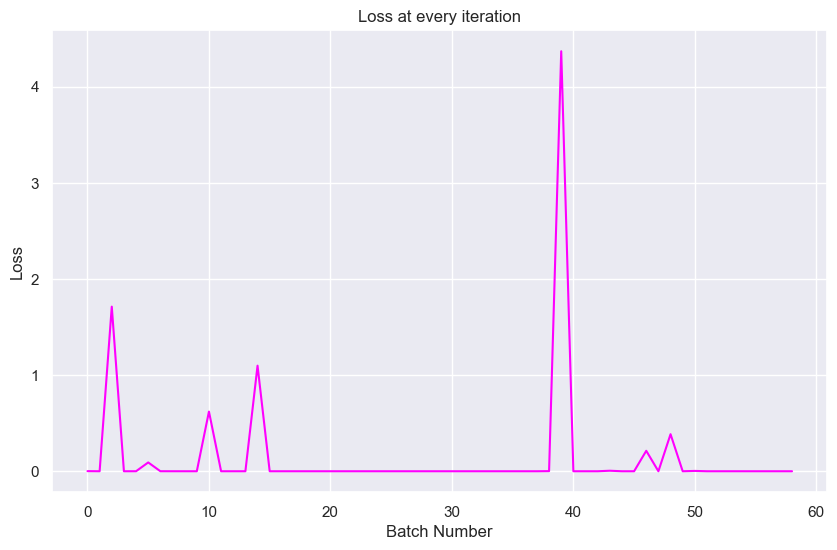

Training complete. Time (mins):  445.24331254959105


In [135]:
# ************************************************************************
# *********     FROM BLANK MODEL:
# *********     Train the recognizer with Stochastic GD
# ************************************************************************

st = time.time()

# create blank Language class
spacy.prefer_gpu()
nlp = spacy.blank('en')  
print("Created blank 'en' model")

# create the built-in pipeline components and add them to the pipeline
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe('ner')
    
# Add labels
for ent_type in ent_labels:
    ner.add_label(ent_type)
print("Entities added to new 'ner'.")

# Disable all pipes other than 'ner' during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# only train NER pipe
with nlp.disable_pipes(*other_pipes):  
    optimizer = nlp.begin_training()
    train_loss = []
    idx_done = 0
    for itn in range(iterations):
        print("Starting iteration " + str(itn))
        
        # Iteration level metrics
        losses = {}
        misalligned_count = 0
        
        # Shuffle training data
        random.shuffle(spacy_training_data)

        #batches = minibatch(spacy_training_data, size=compounding(4., 32., 1.001))
        batches = minibatch(spacy_training_data, size=batch_size)

        batch_no = 0
        for batch in batches:
            print("Starting batch " + str(batch_no))
            for text, annotations in tqdm.tqdm(batch):
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Update the model weights
                losses = nlp.update([example], drop=0.35, sgd=optimizer)
                idx_done+=1
                
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (batch {itn}): {losses}')
            batch_no+=1

            # !CHECKPOINT!
            # Save our trained model into a new directory
            save_fp = model_save_path + "/save_model/"
            if not os.path.isdir(save_fp):
                os.makedirs(save_fp)
            else:
                shutil.rmtree(save_fp)
                os.makedirs(save_fp)
            now = datetime.now()
            fn = "course_nlp___idx_{}__{}".format(str(idx_done), str(now.strftime("%Y_%m_%d__%I_%M_%S_%p")))
            nlp.to_disk(save_fp + fn)
            
            print("Checkpoint saved: ", str(save_fp + fn))
        
    # Visualizing the loss
    plt.figure(figsize=(10,6))
    plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
    plt.title('Loss at every iteration')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.show()

print("Training complete. Time (mins): ", (time.time() - st)/60)

### Resuming Training!

In [122]:
# SET


SET_TRAIN_SIZE = 1000000
SET_BATCH_SIZE = 100000

In [123]:
# :: settings ::

last_index, last_save_model_fp = get_last_model_fp()

# id done till now, need to resume from ??
idx_done_tillnow = int(last_index)
train_begin, train_end =  idx_done_tillnow, idx_done_tillnow + SET_TRAIN_SIZE + 1

# training data
spacy_training_data = train_data[train_begin: train_end]

# creating batches of training data
batch_size = SET_BATCH_SIZE

# Go through the training data N times
iterations = 1

# Save output nlp model
model_save_path = ml_dir + '/models/spacy/courseNER'

# entity labels
ent_labels = {'COURSE_ID', 'COURSE_NAME', 'COURSE_DEPT'}

In [124]:
# ************************************************************************
# *********     RESUME TRAINING!
# *********     
# ************************************************************************

st = time.time()

# load last save nlp model
spacy.prefer_gpu()
nlp = spacy.load(last_save_model_fp)
ner = nlp.get_pipe('ner')
print("Loaded last saved model from ", last_save_model_fp)

# Disable all pipes other than 'ner' during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# only train NER pipe
with nlp.disable_pipes(*other_pipes):
    train_loss = []
    idx_done = idx_done_tillnow
    for itn in range(iterations):
        print("Starting iteration " + str(itn))
        
        # Iteration level metrics
        losses = {}
        misalligned_count = 0
        
        # Shuffle training data
        random.shuffle(spacy_training_data)

        #batches = minibatch(spacy_training_data, size=compounding(4., 32., 1.001))
        batches = minibatch(spacy_training_data, size=batch_size)

        batch_no = 0
        for batch in batches:
            print("Starting batch " + str(batch_no))
            for text, annotations in tqdm.tqdm(batch):
                # create Example
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Update the model
                nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
                # print('Losses', losses)
                idx_done+=1
          
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (batch {itn}): {losses}')
            batch_no+=1

            # CHECKPOINT:
            # Save our trained model into a new directory
            save_fp = model_save_path + "/save_model/"
            if not os.path.isdir(save_fp):
                os.makedirs(save_fp)
            else:
                shutil.rmtree(save_fp)
                os.makedirs(save_fp)
            now = datetime.now()
            fn = "course_nlp___idx_{}__{}".format(str(idx_done), str(now.strftime("%Y_%m_%d__%I_%M_%S_%p")))
            nlp.to_disk(save_fp + fn)
            print("Checkpoint saved: ", str(save_fp + fn))
        
    # Visualizing the loss
    plt.figure(figsize=(10,6))
    plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
    plt.title('Loss at every iteration')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.show()

print("Training complete. Time (mins): ", (time.time() - st)/60)

---

### Approach 2

- Using Spacy Version 3.X model training procedure

In [125]:
# l=set()
# # Add labels
# for _, annotations in train_data:
#      for ent in annotations.get('entities'):
#         l.add(ent[2])

# # Step 3:
# # Save training data in Spacy readable format DocBin
# # error fix: https://github.com/explosion/spaCy/discussions/10255

# # will make 51 "train_{idx}.spacy" DocBin files
# chunk_size = 100000  
# # saves failed attempts
# c, failed, empty = 0, [], []
# for idx in range(0, len(train_data), chunk_size):
#     training_lst = train_data[idx: idx + chunk_size]
#     db = DocBin()
#     for text, annot in tqdm.tqdm(training_lst): # data in previous format
#         try:
#             # create doc object from text
#             doc = nlp.make_doc(text)
#             ents = []
#             for start, end, label in annot["entities"]:
#                 span = doc.char_span(start, end, label=label, alignment_mode="contract")
#                 if span is None:
#                     empty.append((c, text, annot))
#                 else:
#                     ents.append(span)
#             doc.ents = ents # label the text with the ents
#             db.add(doc)
#         except Exception as e:
#             failed.append((c, text, annot))
#         c+=1

#     # save the docbin object
#     db.to_disk(os.path.join(os.path.join(os.path.join(ml_dir, "data"), "train_ner"), "train_{}.spacy".format(idx)))

# print("Number of total empty spans found:", len(empty))
# print("Number of total failed attempts: ", len(failed))

In [126]:
# Step 4: 
# download config file from: https://spacy.io/usage/training#quickstart 
# and store it in "../data/"

In [127]:
# # Step 5:
# # Complete the cofig file using original nlp file

# !python -m spacy init fill-config ../data/base_config.cfg ../data/config.cfg

In [128]:
# # Step 6:
# # Train model

# st = time.time()
# !python -m spacy train ../data/config.cfg --output ../models/spacy/customNER2 --paths.train ../data/train_ner --paths.dev ../data/train_ner --verbose
# print("Total time taken (mins): ", (time.time()-st)/60)

----

# 7. Model Testing

In [10]:
def extract_ents(course_nlp, query, visualize = False):
    
    # preprocessing for query
    query = str(query).strip()
    query = ftfy.fix_text(query)
    query = re.sub(r"([\s\n\t\r]+)", " ", query).strip()
    query = re.sub(r"[\$|\#\@\*\%]+\d+[\$|\#\@\*\%]+", " ", query)
    query = re.sub(r"[\/,\@,\#,\\,\{,\},\(,\),\[,\],\$,\%,\^,\&,\*,\<,\>]", " ", query)
    query = re.sub(r"[\,,\;,\:,\-]", " ", query)
    query = re.sub(r"[\!,\?,\.]", " ", query)
    query = str(query).strip().lower()
    
    doc = course_nlp(query)    
    extracted_entities = []
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))
    # if visualize
    if visualize == True:
        colors = {"COURSE_ID": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
                  "COURSE_NAME": "linear-gradient(90deg, #85C1E9, #85C1E8)",
                  "COURSE_DEPT": "linear-gradient(90deg, #85C1F9, #85C1F9)"}
        options = {"ents": ["COURSE_ID", "COURSE_NAME", "COURSE_DEPT"], "colors": colors}
        html = displacy.render(doc, style = 'ent', options = options)
    return extracted_entities

In [83]:
# Get the latest trained model

spacy_model = '/Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/trained_ner_model_v1.0'
course_nlp = spacy.load(spacy_model)

In [84]:
query = "courses like ACCT 3320"

extract_ents(course_nlp, query.strip().lower(), visualize = True)

[('acct 3320', 13, 22, 'COURSE_ID')]

In [13]:
query = "similar courses to Big Data Architecture??"

extract_ents(course_nlp, query.strip().lower(), visualize = True)

[('big data architecture', 19, 40, 'COURSE_NAME')]

---

# 8. Deployment

In [58]:
# simple queries work like charm!
ner_model.run("recommend courses like machine learning")

[('machine learning', 23, 39, 'COURSE_NAME')]

In [59]:
# covers all courses
ner_model.run("what are the courses similar to Applied Psychology!!")

[('applied psychology', 32, 50, 'COURSE_NAME')]

In [60]:
# ignores spelling mistakes!
ner_model.run("Hey! Provide me a list of coursework related to Big Data Architec??")

[('big data architec', 48, 65, 'COURSE_NAME')]

In [74]:
# ignores noise!
ner_model.run("Okay, recommend for Textual analysis in business, what are some good choices?")

[('textual analysis in business', 20, 48, 'COURSE_NAME')]

In [ ]:
Feminist Methodology	

In [80]:
# ignores noise!
ner_model.run("coursework from Department of Women's and Gender Studies?")

[("department of women's and gender studies", 16, 56, 'COURSE_DEPT')]

In [81]:
"""
WGST 6190	Feminist Methodology	WGST	Department of Women's and Gender Studies
"""

# covers course IDs as well!
ner_model.run("coursework for WGST 6190")

[('wgst 6190', 15, 24, 'COURSE_ID')]

----

X-X

----